In [1]:
from distributed import Executor, progress

In [2]:
e = Executor('dscheduler:8786')

In [3]:
e.restart()

<Executor: scheduler=dscheduler:8786 processes=3 cores=96>

In [4]:
import subprocess


def install_libs():
    libs = 'scikit-learn pandas matplotlib'.split()
    return subprocess.check_call('conda install -yq'.split() + libs)

install_libs()

0

In [5]:
e.run(install_libs)

{'10.112.0.6:47586': 0, '10.112.1.4:40022': 0, '10.112.2.3:46385': 0}

In [6]:
def my_add(a, b):
    return a + b

f1 = e.submit(my_add, 1, 2)

In [7]:
f1

<Future: status: finished, type: int, key: my_add-df74d51e74b6ca08d254db0f26dac8cc>

In [8]:
f1.result()

3

In [9]:
f2 = e.submit(my_add, f1, 39)

In [10]:
f2.result()

42

In [11]:
from time import sleep

n_cores = sum(e.ncores().values())
futures = e.map(sleep, [0.1] * (n_cores * 100), pure=False)
progress(futures)

In [12]:
from sklearn.datasets import load_digits
import numpy as np

digits = load_digits()

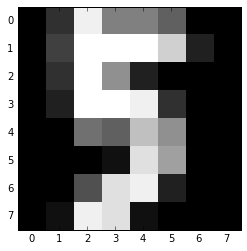

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(digits.data[35].reshape(8, 8),
           interpolation='nearest', cmap='gray');

In [18]:
from sklearn.cross_validation import train_test_split


def load_cv_split(split_idx):
    data = load_digits()
    splitted = train_test_split(data.data, data.target,
                                test_size=0.20,
                                random_state=split_idx)
    return split_idx, splitted

In [19]:
from time import time
from sklearn.externals.joblib import hash


def evaluate_one(model_class, parameters, cv_split):
    split_idx, (X_train, X_val, y_train, y_val) = cv_split
    t0 = time()
    model = model_class(**parameters).fit(X_train, y_train)
    training_time = time() - t0

    train_score = model.score(X_train, y_train)
    validation_score = model.score(X_val, y_val)
    
    results = {
        'split_idx': split_idx,
        'training_time': training_time,
        'train_score': train_score,
        'val_score': validation_score,
        'parameters': parameters,
        'parameters_hash': hash(parameters),
    }
    return results

In [20]:
from dask import delayed
from sklearn.svm import SVC
from sklearn.grid_search import ParameterSampler
import numpy as np

param_grid = {
    'C': np.logspace(-10, 10, 1001),
    'gamma': np.logspace(-10, 10, 1001),
    'tol': np.logspace(-4, -1, 4),
}
param_space = ParameterSampler(param_grid, n_cores * 10)

cv_splits = [delayed(load_cv_split)(i) for i in range(3)]
        
delayed_evaluations = [delayed(evaluate_one)(SVC, params, split)
                       for split in cv_splits
                       for params in param_space]

In [21]:
delayed_evaluations[:5]

[Delayed('evaluate_one-329ed694-54a3-4939-89a8-e959a1525fdf'),
 Delayed('evaluate_one-73ccb900-cb7c-4ea2-b307-6c620395e8c5'),
 Delayed('evaluate_one-527263c3-f0fc-41e4-ab2e-ad52d502645d'),
 Delayed('evaluate_one-0c477da5-e6fa-4464-a922-c8c6ebd40748'),
 Delayed('evaluate_one-fa694581-ccbf-4497-85c2-2cc11e75779b')]

In [22]:
delayed_evaluations[0].compute()

{'parameters': {'C': 2290.8676527677699,
  'gamma': 9.1201083935590964e-08,
  'tol': 0.001},
 'parameters_hash': '32c77342ed4a93d68a1d02d9ecc1001d',
 'split_idx': 0,
 'train_score': 0.98469032707028536,
 'training_time': 0.0822751522064209,
 'val_score': 0.97777777777777775}

In [23]:
all_results = e.compute(delayed_evaluations)

In [24]:
progress(all_results)

In [28]:
len([f for f in all_results if f.done()])

2880

In [29]:
import pandas as pd
results = e.gather([f for f in all_results if f.done()])
results = pd.DataFrame.from_dict(results)
results.describe()

,split_idx,train_score,training_time,val_score
count,2880.000000,2880.000000,2880.000000,2880.000000
mean,1.000000,0.545461,0.594582,0.254412
std,0.816638,0.444052,0.221165,0.349048
min,0.000000,0.105776,0.060875,0.077778
25%,0.000000,0.105776,0.589693,0.077778
50%,1.000000,0.107168,0.651569,0.080556
75%,2.000000,1.000000,0.712650,0.083333
max,2.000000,1.000000,1.289349,0.994444


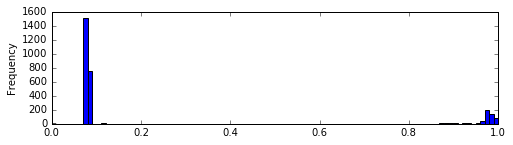

In [30]:
plt.figure(figsize=(8, 2))
bins = np.linspace(0, 1, 100)
results['val_score'].plot(kind='hist', bins=bins);

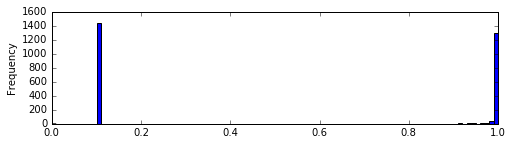

In [31]:
plt.figure(figsize=(8, 2))
results['train_score'].plot.hist(bins=bins);

In [32]:
from joblib import hash

mean_evaluations = results.groupby('parameters_hash').agg({
    'train_score': np.mean,
    'val_score': np.mean,
    'training_time': np.mean,
}).reset_index()

mean_evaluations.head(5)

,parameters_hash,train_score,val_score,training_time
0,0027022440edcd2f64f3d1a6a20aa323,1.000000,0.744444,0.823555
1,00463b3b6630725e10bca0f12fafa360,0.107168,0.080556,0.747670
2,004c553aad5a2cc22542a6ed0fecd25a,0.979819,0.977778,0.238109
3,005ab8ac995335084fc80e61afa403e9,1.000000,0.077778,0.763621
4,006bb05b124e85b9005509495d201b1a,0.107168,0.080556,0.641791


In [33]:
all_parameters = pd.DataFrame.from_dict(list(results['parameters']))
all_parameters['parameters_hash'] = results['parameters_hash']

evaluations = (
    mean_evaluations
    .merge(all_parameters)
    .drop(['parameters_hash'], axis=1)
)

In [34]:
top10 = evaluations.sort_values(
    by='val_score', ascending=False).head(10)
top10

,train_score,val_score,training_time,C,gamma,tol
1967,0.997912,0.994444,0.191686,6.606934e-01,9.120108e-04,0.0100
2047,0.993737,0.994444,0.265911,3.467369e-01,1.047129e-03,0.0001
1099,0.999304,0.994444,0.222865,9.549926e-01,1.445440e-03,0.1000
1683,0.999304,0.994444,0.249131,1.000000e+00,1.318257e-03,0.0001
999,0.988866,0.991667,0.092361,1.380384e+02,3.801894e-06,0.0100
1605,1.000000,0.991667,0.095041,6.606934e+06,6.025596e-08,0.0001
2442,0.995129,0.991667,0.114434,6.606934e+00,1.148154e-04,0.0001
2296,1.000000,0.991667,0.182144,7.585776e+03,6.025596e-04,0.0001
2765,1.000000,0.991667,0.067027,1.819701e+06,2.884032e-07,0.1000
829,1.000000,0.991667,0.168076,8.317638e+09,1.318257e-08,0.0010


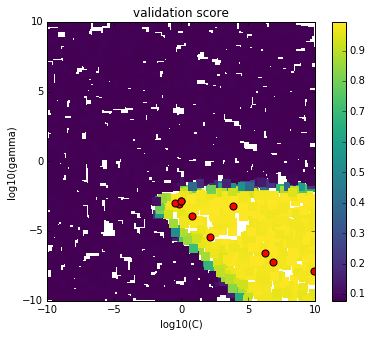

In [35]:
import matplotlib.pyplot as plt

def plot_param_map(df, target, title):
    plt.xlabel('log10(C)')
    plt.ylabel('log10(gamma)')
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.scatter(np.log10(df['C']), np.log10(df['gamma']),
                c=target,
                marker='s', edgecolors='none',
                s=80, alpha=1, cmap='viridis')
    plt.colorbar()
    plt.title(title)

plt.figure(figsize=(6, 5))
plot_param_map(evaluations, evaluations['val_score'],
               'validation score')
plt.scatter(np.log10(top10['C']), np.log10(top10['gamma']),
            c='r', s=50);

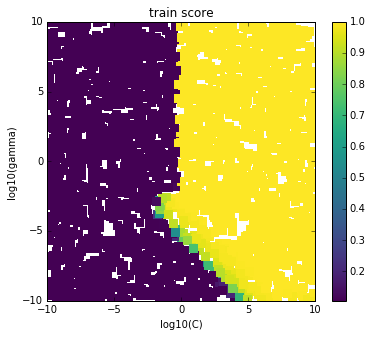

In [36]:
plt.figure(figsize=(6, 5))
plot_param_map(evaluations, evaluations['train_score'], 'train score')

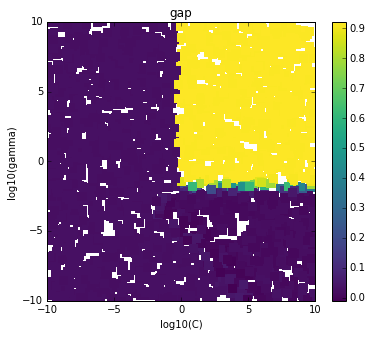

In [37]:
plt.figure(figsize=(6, 5))
gap = evaluations['train_score'] - evaluations['val_score']
plot_param_map(evaluations, gap, 'gap')

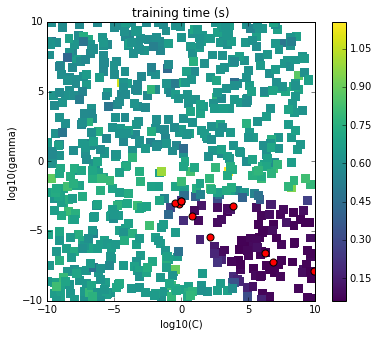

In [38]:
plt.figure(figsize=(6, 5))
high_tol = evaluations[evaluations['tol'] == 0.1]

plot_param_map(high_tol, high_tol['training_time'], 'training time (s)')
plt.scatter(np.log10(top10['C']), np.log10(top10['gamma']),
            c='r', s=50);

## Scaling down

### Distributed cluster

In [39]:
import dask

%time _ = dask.compute(*delayed_evaluations[:10], get=e.get)

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 986 ms


### Single host, local python process, multiple threads

In [40]:
%time _ = dask.compute(*delayed_evaluations[:10])

CPU times: user 5.3 s, sys: 52 ms, total: 5.35 s
Wall time: 970 ms


### Single host, local python process, no parallelism

In [41]:
from dask.async import get_sync

%time _ = dask.compute(*delayed_evaluations[:10], get=get_sync)

CPU times: user 5.3 s, sys: 0 ns, total: 5.3 s
Wall time: 5.26 s


In [42]:
%prun _ = dask.compute(*delayed_evaluations[:10], get=get_sync)